In [58]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def calculate_correlations(shap_values, features_df, feature_names, num_classes):
    correlation_df = pd.DataFrame()

    for feature in feature_names:
        correlation_dict = {'feature': feature}

        for i in range(num_classes):
            shap_values_i = shap_values[i][:, features_df.columns.get_loc(feature)]
            feature_values_i = features_df[feature].values

            correlation_coefficient_i = np.corrcoef(shap_values_i, feature_values_i)[0, 1]
            correlation_dict[f'correlation_{i}'] = correlation_coefficient_i

        correlation_df = correlation_df.append(correlation_dict, ignore_index=True)

    return correlation_df

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 5,
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    
    # データをpandas.DataFrame形式で保存
    #X_train_df = pd.DataFrame(X_train, columns=column_names)
    #y_train_df = pd.DataFrame(y_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
        
    return X_train, y_train, bst

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df

In [67]:
# 1秒ごとのデータに分割
#n_samples_per_second = 128  # 128Hzのサンプリングレート
#total_seconds = 10  # 全体の秒数

# データの読み込み
#df = pd.read_csv('ALL.csv') # 99.48%
#df = pd.read_csv('ALL_RightLeft.csv') # 99.58%
#df = pd.read_csv('ALL_UpperUnder.csv') # 99.69%
df = pd.read_csv('H_all.csv')
df_y = pd.read_csv('ALL.csv')
df = pd.concat([df,df_y])

"""""
# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
"""""

'""\n# チャンネルごとに正規化\nscaler = StandardScaler()\nfor column in df.columns[:-1]:  # \'State\'列を除くすべての列\n    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))\n'

In [68]:
# Hzごと
# 特徴量と目的変数を抽出する
X = df.drop('Label', axis=1)  # 'Label'以外の列
#X = df.drop([ 'P1',  'Oz', 'P2','Label','Fp1','Fp2','F3','F4','Fz','O1','O2','P3','Pz','P4'], axis=1)  # '10/20法
#X = df[['T7','T8','C5','C6']]
y = df['Label']  # 'Label'を目標変数

#XGBoost
X_train_df, y_train_df, bst = XGBoost(X, y)

[0]	train-mlogloss:1.48560	eval-mlogloss:1.48972
[1]	train-mlogloss:1.38282	eval-mlogloss:1.39012
[2]	train-mlogloss:1.29601	eval-mlogloss:1.30659
[3]	train-mlogloss:1.22123	eval-mlogloss:1.23474
[4]	train-mlogloss:1.14697	eval-mlogloss:1.16289
[5]	train-mlogloss:1.08079	eval-mlogloss:1.09756
[6]	train-mlogloss:1.02420	eval-mlogloss:1.04224
[7]	train-mlogloss:0.97382	eval-mlogloss:0.99276
[8]	train-mlogloss:0.92926	eval-mlogloss:0.94904
[9]	train-mlogloss:0.88288	eval-mlogloss:0.90333
[10]	train-mlogloss:0.84360	eval-mlogloss:0.86485
[11]	train-mlogloss:0.80538	eval-mlogloss:0.82739
[12]	train-mlogloss:0.76915	eval-mlogloss:0.79214
[13]	train-mlogloss:0.73905	eval-mlogloss:0.76357
[14]	train-mlogloss:0.71054	eval-mlogloss:0.73549
[15]	train-mlogloss:0.68350	eval-mlogloss:0.70943
[16]	train-mlogloss:0.65948	eval-mlogloss:0.68632
[17]	train-mlogloss:0.63846	eval-mlogloss:0.66630
[18]	train-mlogloss:0.61638	eval-mlogloss:0.64480
[19]	train-mlogloss:0.59689	eval-mlogloss:0.62571
[20]	train

[163]	train-mlogloss:0.02560	eval-mlogloss:0.05011
[164]	train-mlogloss:0.02526	eval-mlogloss:0.04968
[165]	train-mlogloss:0.02482	eval-mlogloss:0.04918
[166]	train-mlogloss:0.02448	eval-mlogloss:0.04873
[167]	train-mlogloss:0.02410	eval-mlogloss:0.04820
[168]	train-mlogloss:0.02373	eval-mlogloss:0.04789
[169]	train-mlogloss:0.02337	eval-mlogloss:0.04737
[170]	train-mlogloss:0.02294	eval-mlogloss:0.04674
[171]	train-mlogloss:0.02261	eval-mlogloss:0.04623
[172]	train-mlogloss:0.02223	eval-mlogloss:0.04577
[173]	train-mlogloss:0.02192	eval-mlogloss:0.04535
[174]	train-mlogloss:0.02160	eval-mlogloss:0.04499
[175]	train-mlogloss:0.02135	eval-mlogloss:0.04468
[176]	train-mlogloss:0.02097	eval-mlogloss:0.04424
[177]	train-mlogloss:0.02066	eval-mlogloss:0.04385
[178]	train-mlogloss:0.02047	eval-mlogloss:0.04374
[179]	train-mlogloss:0.02018	eval-mlogloss:0.04339
[180]	train-mlogloss:0.01988	eval-mlogloss:0.04308
[181]	train-mlogloss:0.01960	eval-mlogloss:0.04272
[182]	train-mlogloss:0.01930	ev

[324]	train-mlogloss:0.00349	eval-mlogloss:0.01882
[325]	train-mlogloss:0.00346	eval-mlogloss:0.01874
[326]	train-mlogloss:0.00343	eval-mlogloss:0.01866
[327]	train-mlogloss:0.00340	eval-mlogloss:0.01863
[328]	train-mlogloss:0.00335	eval-mlogloss:0.01852
[329]	train-mlogloss:0.00333	eval-mlogloss:0.01846
[330]	train-mlogloss:0.00329	eval-mlogloss:0.01838
[331]	train-mlogloss:0.00327	eval-mlogloss:0.01832
[332]	train-mlogloss:0.00323	eval-mlogloss:0.01824
[333]	train-mlogloss:0.00320	eval-mlogloss:0.01819
[334]	train-mlogloss:0.00317	eval-mlogloss:0.01817
[335]	train-mlogloss:0.00314	eval-mlogloss:0.01812
[336]	train-mlogloss:0.00311	eval-mlogloss:0.01807
[337]	train-mlogloss:0.00309	eval-mlogloss:0.01800
[338]	train-mlogloss:0.00306	eval-mlogloss:0.01795
[339]	train-mlogloss:0.00303	eval-mlogloss:0.01791
[340]	train-mlogloss:0.00300	eval-mlogloss:0.01785
[341]	train-mlogloss:0.00297	eval-mlogloss:0.01774
[342]	train-mlogloss:0.00295	eval-mlogloss:0.01770
[343]	train-mlogloss:0.00293	ev

[485]	train-mlogloss:0.00125	eval-mlogloss:0.01384
[486]	train-mlogloss:0.00125	eval-mlogloss:0.01384
[487]	train-mlogloss:0.00124	eval-mlogloss:0.01383
[488]	train-mlogloss:0.00124	eval-mlogloss:0.01382
[489]	train-mlogloss:0.00123	eval-mlogloss:0.01382
[490]	train-mlogloss:0.00123	eval-mlogloss:0.01379
[491]	train-mlogloss:0.00122	eval-mlogloss:0.01378
[492]	train-mlogloss:0.00121	eval-mlogloss:0.01375
[493]	train-mlogloss:0.00121	eval-mlogloss:0.01373
[494]	train-mlogloss:0.00121	eval-mlogloss:0.01372
[495]	train-mlogloss:0.00120	eval-mlogloss:0.01373
[496]	train-mlogloss:0.00120	eval-mlogloss:0.01370
[497]	train-mlogloss:0.00119	eval-mlogloss:0.01367
[498]	train-mlogloss:0.00119	eval-mlogloss:0.01368
[499]	train-mlogloss:0.00118	eval-mlogloss:0.01367
[500]	train-mlogloss:0.00118	eval-mlogloss:0.01366
[501]	train-mlogloss:0.00117	eval-mlogloss:0.01366
[502]	train-mlogloss:0.00117	eval-mlogloss:0.01366
[503]	train-mlogloss:0.00116	eval-mlogloss:0.01366
[504]	train-mlogloss:0.00116	ev

[646]	train-mlogloss:0.00077	eval-mlogloss:0.01236
[647]	train-mlogloss:0.00077	eval-mlogloss:0.01237
[648]	train-mlogloss:0.00076	eval-mlogloss:0.01235
[649]	train-mlogloss:0.00076	eval-mlogloss:0.01235
[650]	train-mlogloss:0.00076	eval-mlogloss:0.01236
[651]	train-mlogloss:0.00076	eval-mlogloss:0.01237
[652]	train-mlogloss:0.00076	eval-mlogloss:0.01237
[653]	train-mlogloss:0.00076	eval-mlogloss:0.01236
[654]	train-mlogloss:0.00075	eval-mlogloss:0.01235
[655]	train-mlogloss:0.00075	eval-mlogloss:0.01236
[656]	train-mlogloss:0.00075	eval-mlogloss:0.01235
[657]	train-mlogloss:0.00075	eval-mlogloss:0.01235
[658]	train-mlogloss:0.00075	eval-mlogloss:0.01234
[659]	train-mlogloss:0.00075	eval-mlogloss:0.01234
[660]	train-mlogloss:0.00075	eval-mlogloss:0.01233
[661]	train-mlogloss:0.00074	eval-mlogloss:0.01233
[662]	train-mlogloss:0.00074	eval-mlogloss:0.01232
[663]	train-mlogloss:0.00074	eval-mlogloss:0.01231
[664]	train-mlogloss:0.00074	eval-mlogloss:0.01230
[665]	train-mlogloss:0.00074	ev

[807]	train-mlogloss:0.00059	eval-mlogloss:0.01173
[808]	train-mlogloss:0.00059	eval-mlogloss:0.01173
[809]	train-mlogloss:0.00059	eval-mlogloss:0.01171
[810]	train-mlogloss:0.00059	eval-mlogloss:0.01170
[811]	train-mlogloss:0.00059	eval-mlogloss:0.01170
[812]	train-mlogloss:0.00059	eval-mlogloss:0.01172
[813]	train-mlogloss:0.00059	eval-mlogloss:0.01170
[814]	train-mlogloss:0.00059	eval-mlogloss:0.01169
[815]	train-mlogloss:0.00059	eval-mlogloss:0.01169
[816]	train-mlogloss:0.00059	eval-mlogloss:0.01168
[817]	train-mlogloss:0.00059	eval-mlogloss:0.01168
[818]	train-mlogloss:0.00059	eval-mlogloss:0.01168
[819]	train-mlogloss:0.00059	eval-mlogloss:0.01168
[820]	train-mlogloss:0.00059	eval-mlogloss:0.01168
[821]	train-mlogloss:0.00058	eval-mlogloss:0.01167
[822]	train-mlogloss:0.00058	eval-mlogloss:0.01167
[823]	train-mlogloss:0.00058	eval-mlogloss:0.01168
[824]	train-mlogloss:0.00058	eval-mlogloss:0.01168
[825]	train-mlogloss:0.00058	eval-mlogloss:0.01167
[826]	train-mlogloss:0.00058	ev

[968]	train-mlogloss:0.00051	eval-mlogloss:0.01143
[969]	train-mlogloss:0.00051	eval-mlogloss:0.01144
[970]	train-mlogloss:0.00051	eval-mlogloss:0.01143
[971]	train-mlogloss:0.00051	eval-mlogloss:0.01143
[972]	train-mlogloss:0.00051	eval-mlogloss:0.01143
[973]	train-mlogloss:0.00050	eval-mlogloss:0.01143
[974]	train-mlogloss:0.00050	eval-mlogloss:0.01144
[975]	train-mlogloss:0.00050	eval-mlogloss:0.01144
[976]	train-mlogloss:0.00050	eval-mlogloss:0.01144
[977]	train-mlogloss:0.00050	eval-mlogloss:0.01143
[978]	train-mlogloss:0.00050	eval-mlogloss:0.01144
[979]	train-mlogloss:0.00050	eval-mlogloss:0.01143
[980]	train-mlogloss:0.00050	eval-mlogloss:0.01143
[981]	train-mlogloss:0.00050	eval-mlogloss:0.01141
[982]	train-mlogloss:0.00050	eval-mlogloss:0.01142
[983]	train-mlogloss:0.00050	eval-mlogloss:0.01141
[984]	train-mlogloss:0.00050	eval-mlogloss:0.01141
[985]	train-mlogloss:0.00050	eval-mlogloss:0.01141
[986]	train-mlogloss:0.00050	eval-mlogloss:0.01141
[987]	train-mlogloss:0.00050	ev

[1127]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1128]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1129]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1130]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1131]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1132]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1133]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1134]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1135]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1136]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1137]	train-mlogloss:0.00046	eval-mlogloss:0.01122
[1138]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1139]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1140]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1141]	train-mlogloss:0.00046	eval-mlogloss:0.01121
[1142]	train-mlogloss:0.00045	eval-mlogloss:0.01120
[1143]	train-mlogloss:0.00045	eval-mlogloss:0.01120
[1144]	train-mlogloss:0.00045	eval-mlogloss:0.01120
[1145]	train-mlogloss:0.00045	eval-mlogloss:0.01120
[1146]	train

[1284]	train-mlogloss:0.00043	eval-mlogloss:0.01112
[1285]	train-mlogloss:0.00043	eval-mlogloss:0.01111
[1286]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1287]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1288]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1289]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1290]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1291]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1292]	train-mlogloss:0.00043	eval-mlogloss:0.01110
[1293]	train-mlogloss:0.00043	eval-mlogloss:0.01111
[1294]	train-mlogloss:0.00043	eval-mlogloss:0.01111
[1295]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1296]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1297]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1298]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1299]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1300]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1301]	train-mlogloss:0.00042	eval-mlogloss:0.01111
[1302]	train-mlogloss:0.00042	eval-mlogloss:0.01110
[1303]	train

[1442]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1443]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1444]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1445]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1446]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1447]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1448]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1449]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1450]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1451]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1452]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1453]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1454]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1455]	train-mlogloss:0.00040	eval-mlogloss:0.01100
[1456]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1457]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1458]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1459]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1460]	train-mlogloss:0.00040	eval-mlogloss:0.01099
[1461]	train

[1600]	train-mlogloss:0.00039	eval-mlogloss:0.01094
[1601]	train-mlogloss:0.00039	eval-mlogloss:0.01094
[1602]	train-mlogloss:0.00038	eval-mlogloss:0.01094
[1603]	train-mlogloss:0.00038	eval-mlogloss:0.01094
[1604]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1605]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1606]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1607]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1608]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1609]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1610]	train-mlogloss:0.00038	eval-mlogloss:0.01096
[1611]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1612]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1613]	train-mlogloss:0.00038	eval-mlogloss:0.01096
[1614]	train-mlogloss:0.00038	eval-mlogloss:0.01096
[1615]	train-mlogloss:0.00038	eval-mlogloss:0.01096
[1616]	train-mlogloss:0.00038	eval-mlogloss:0.01096
[1617]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1618]	train-mlogloss:0.00038	eval-mlogloss:0.01095
[1619]	train

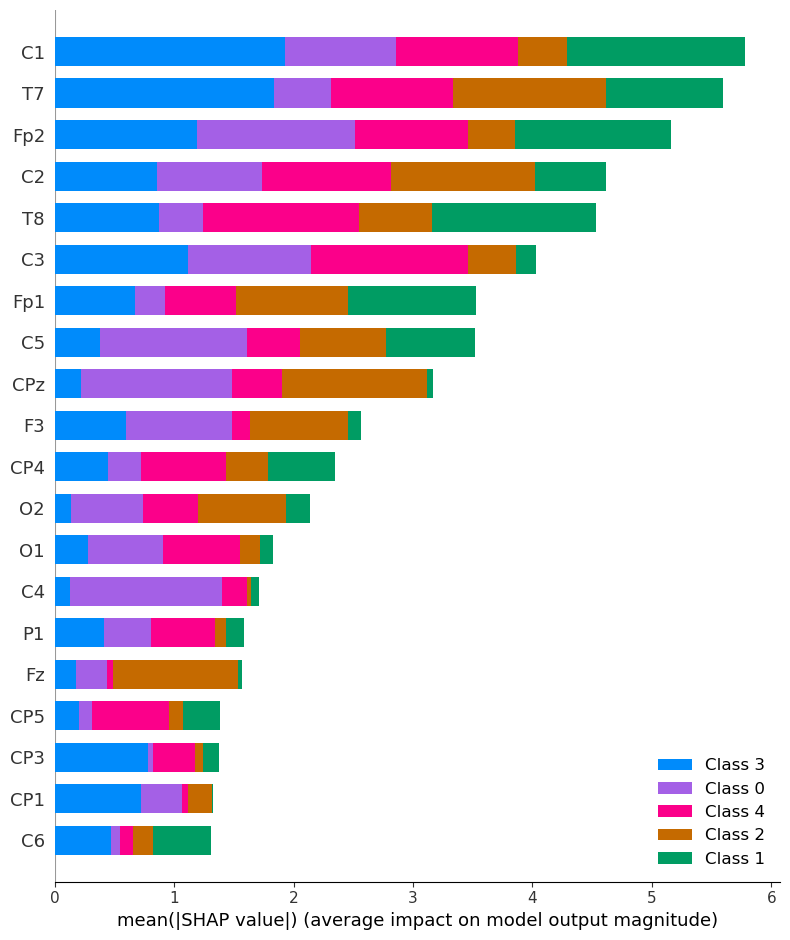

In [70]:
#各特徴重要度を表示する
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train_df,y_train_df)

shap.summary_plot(shap_values, X_train_df)
#0 普通
#1 右手
#2 左手
#3 右足
#4 左足

In [74]:
df_y = pd.read_csv('ALL.csv') 

In [75]:
#X = df_y.drop([ 'P1',  'Oz', 'P2','Label','Fp1','Fp2','F3','F4','Fz','O1','O2','P3','Pz','P4'], axis=1)  # '10/20法
X = df_y.drop(["Label"],axis=1)
y = df_y["Label"]
test = xgb.DMatrix(X,label=y)

In [76]:
pred = bst.predict(test)
test_accuracy = accuracy_score(y, pred)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 99.94%


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


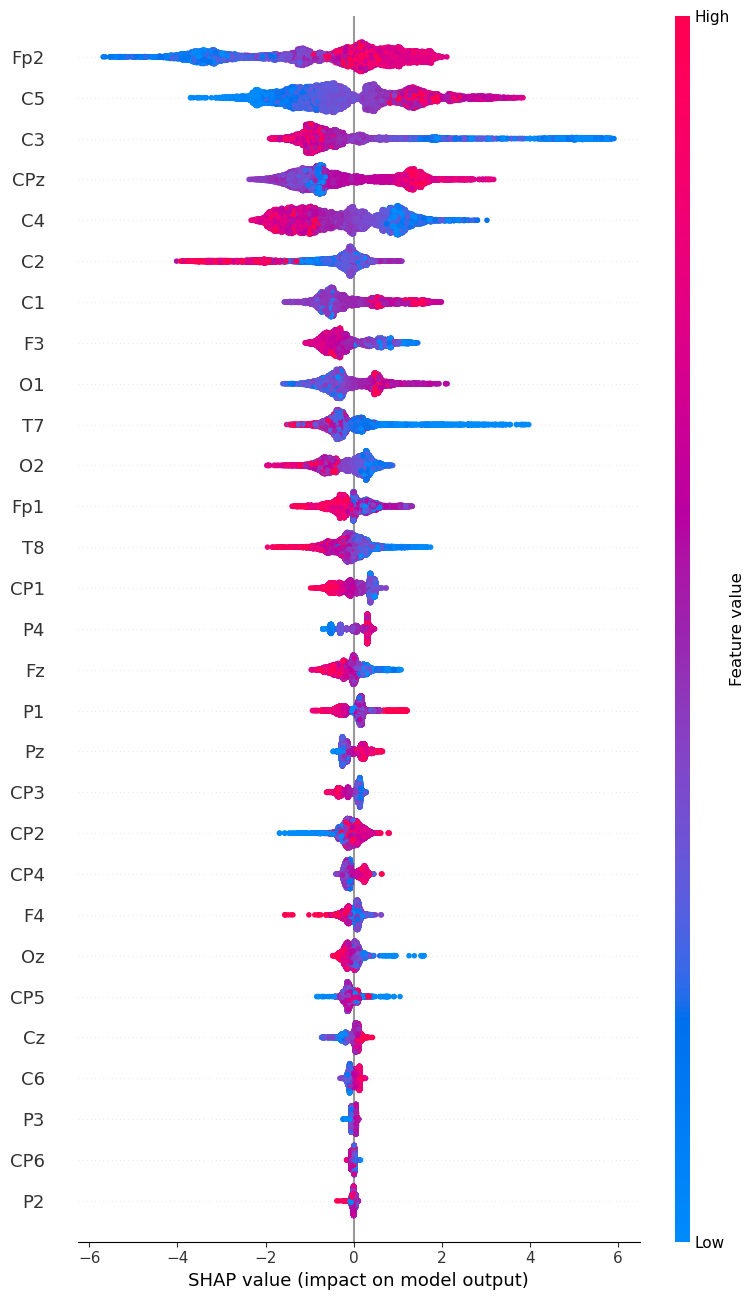

In [40]:
# SHAP値をプロット
shap.summary_plot(shap_values[0], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[0], X_train_df)
# 普通

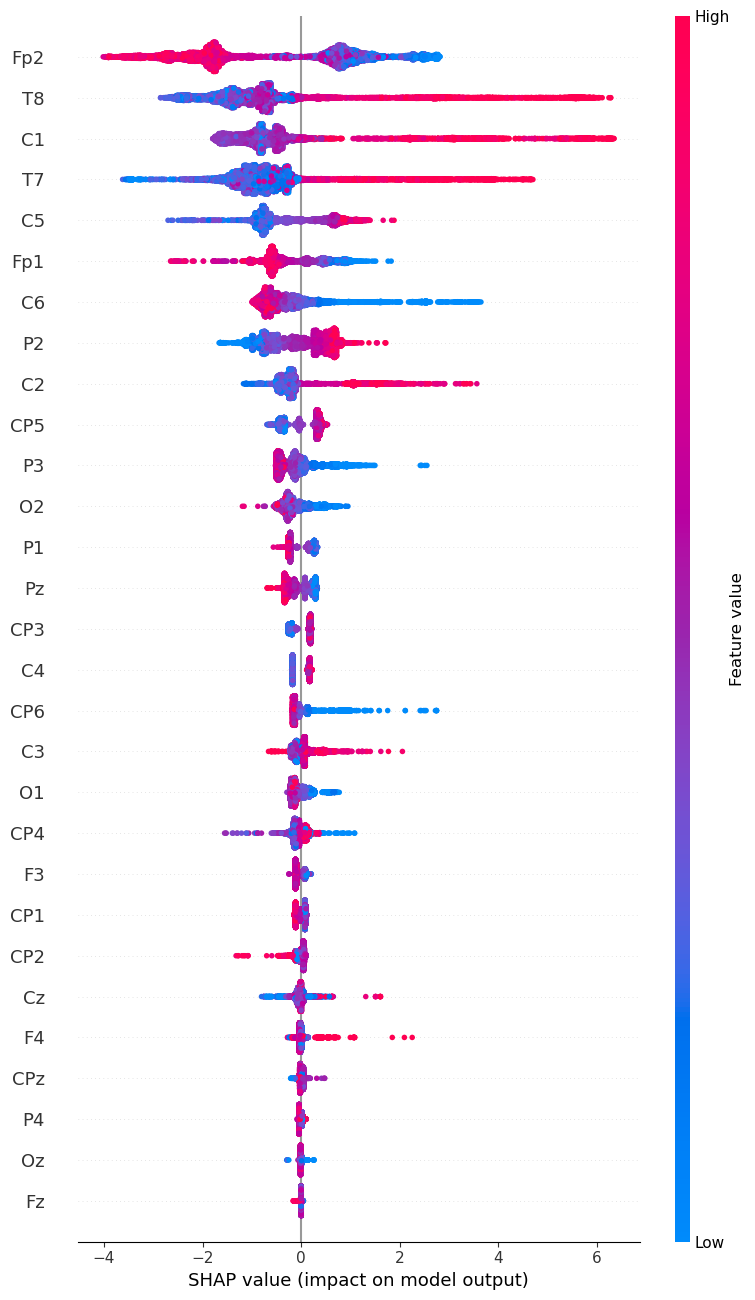

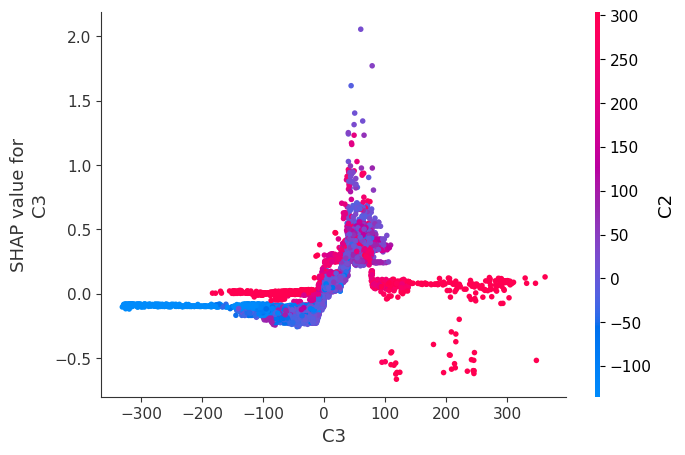

In [41]:
# SHAP値をプロット
shap.summary_plot(shap_values[1], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("C3", shap_values[1], X_train_df)
# 右手

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


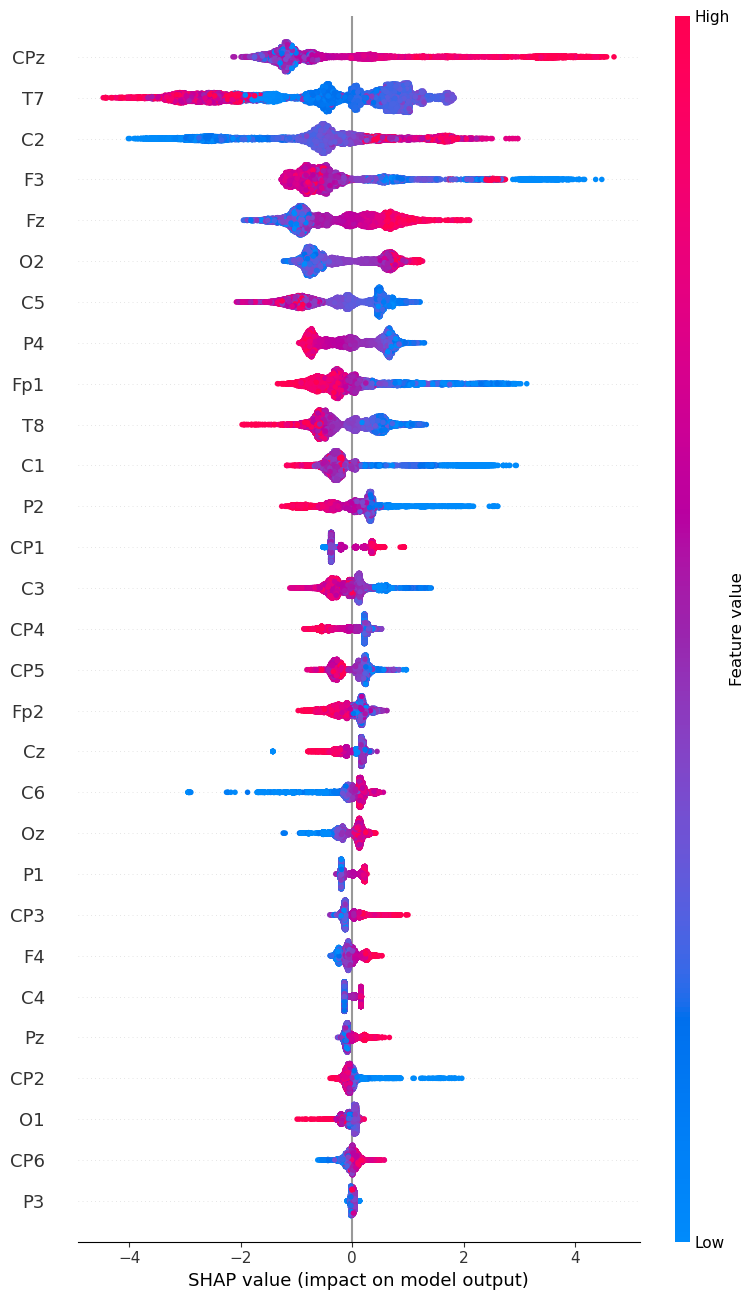

In [42]:
# SHAP値をプロット
shap.summary_plot(shap_values[2], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左手

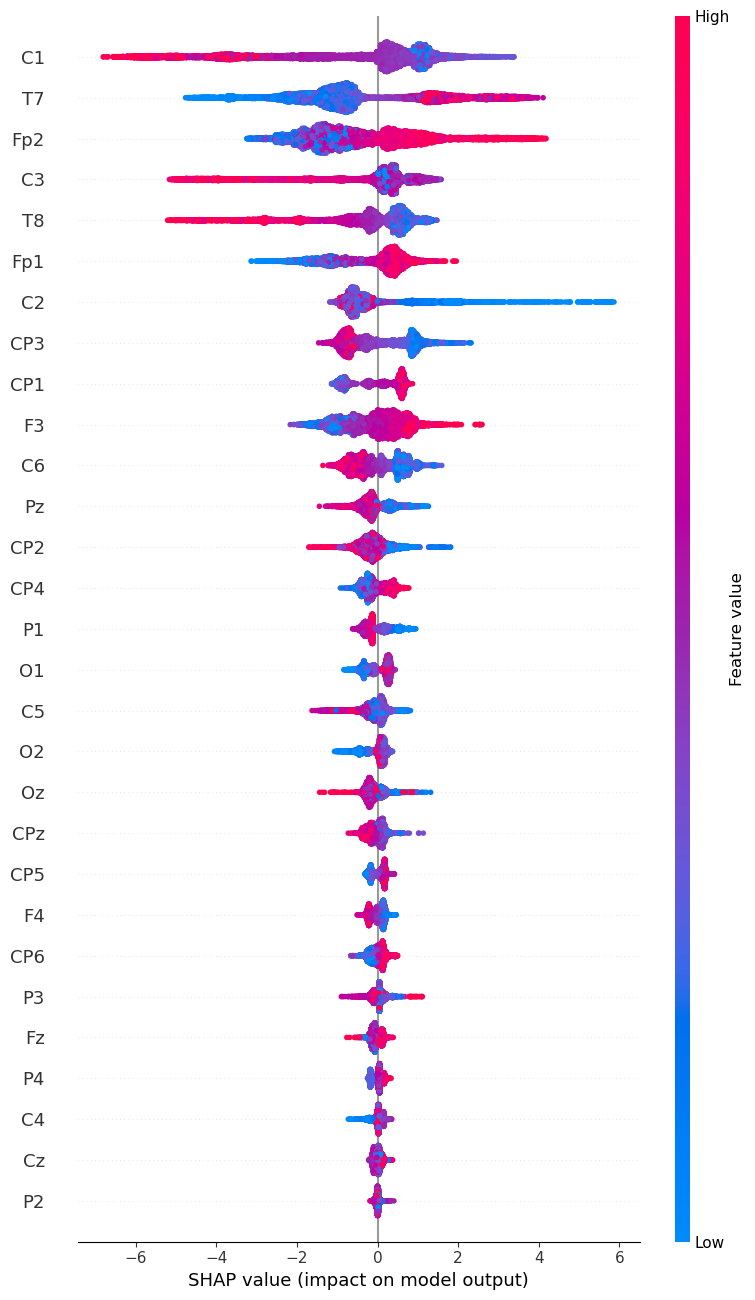

In [43]:
# SHAP値をプロット
shap.summary_plot(shap_values[3], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 右足

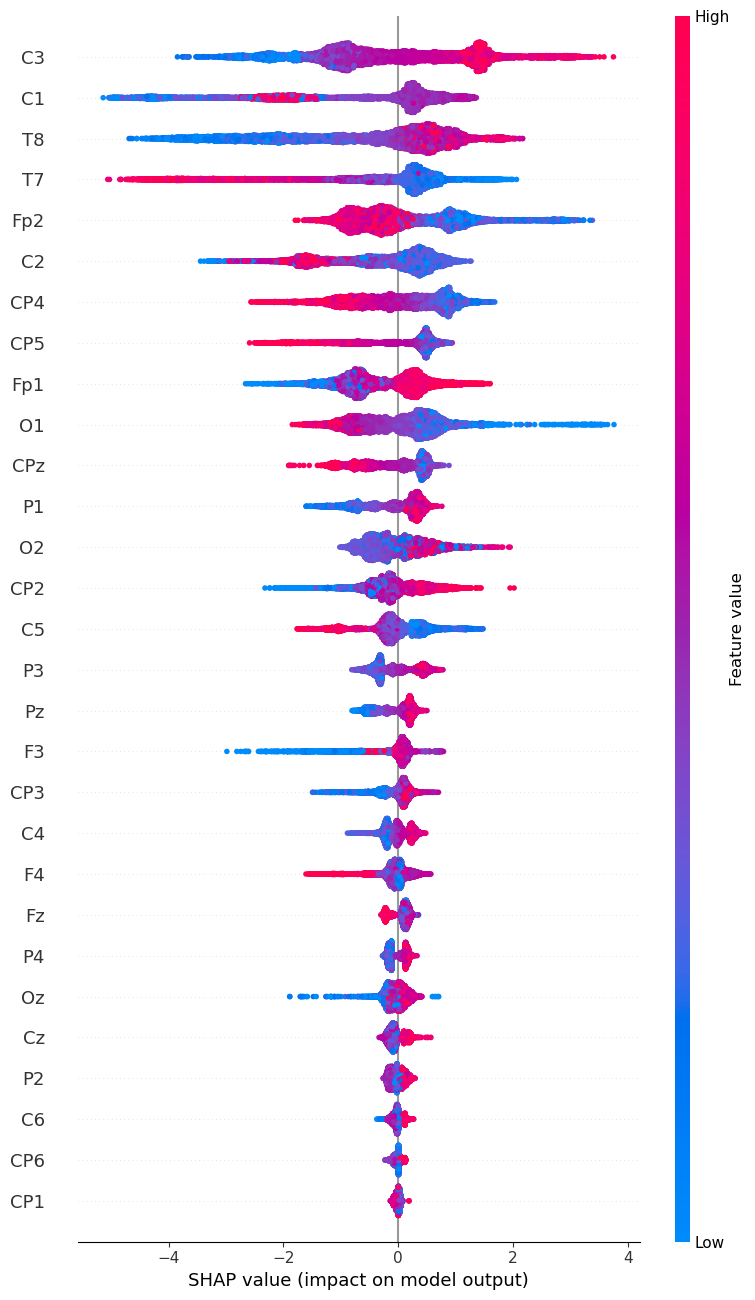

In [44]:
# SHAP値をプロット
shap.summary_plot(shap_values[4], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左足

In [10]:
num_classes = 5  # クラス数を設定
correlation_df = calculate_correlations(shap_values, X_train_df, column_names, num_classes).T
correlation_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
feature,Cz,Fz,Fp1,F3,C1,C3,T7,C5,CP5,CP3,...,P2,CP2,CP4,CP6,C6,T8,C4,C2,F4,Fp2
correlation_0,0.810988,-0.766331,-0.625519,-0.612685,0.862686,-0.758824,-0.297234,0.788873,-0.632299,-0.809433,...,-0.697578,0.106143,-0.241362,0.795139,-0.700924,-0.872544,-0.59979,0.532927,-0.640828,0.868505
correlation_1,-0.769314,-0.463344,-0.804074,-0.532088,-0.455273,0.85354,0.924133,0.722813,0.560965,NaN,...,0.78542,-0.374326,0.81424,-0.831902,-0.669027,0.892211,0.141122,0.121532,-0.718754,-0.008991
correlation_2,-0.781393,0.693305,-0.731118,-0.685555,0.794201,-0.720798,-0.708802,-0.695566,0.822583,0.569177,...,-0.564023,-0.317611,-0.639801,-0.804692,-0.448782,-0.78174,-0.581498,0.256973,0.641458,0.792439
correlation_3,0.800697,-0.488101,0.85363,0.631584,-0.664009,0.326075,0.799863,-0.731817,0.580333,-0.697619,...,-0.776853,0.667152,0.659022,0.823234,0.765331,-0.877457,0.468709,-0.287248,-0.046952,-0.489249
correlation_4,0.443738,0.814355,0.730295,0.799195,-0.879276,0.75615,-0.892087,-0.87551,-0.802491,-0.706897,...,0.818273,-0.058002,-0.851632,0.761499,0.766336,0.798987,-0.480074,-0.849,-0.704647,-0.78582
